In [1]:
%pip install -e ..
%load_ext autoreload
%autoreload 2

Obtaining file:///C:/Users/USER/Desktop/projects/Credit%20Score%20Modelling
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for credit-score-modelling (pyproject.toml): started
  Building editable for credit-score-modelling (pyproject.toml): finished with status 'done'
  Created wheel for credit-score-modelling: filename=credit_score_modelling-0.1.0-0.editable-py3-none-any.whl size=2389 sha256=bc2a7687e85785942ea7d0c5b7d75f19870f6089eacff0601cac2806c3046fc8
  Stored in directory: C:\Users\USER\AppData\Local\Temp\pip-ephem-whee


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:

from credit_score.features import load_split

In [7]:
df = load_split("train")

In [8]:
df.shape

(35000, 33)

In [22]:
df_test = load_split("test")
df_val = load_split("val")
df_val.shape, df_test.shape

((10000, 33), (5000, 33))

<h3 align='center' style="color:pink"> Data Cleaning </h3>

#### Dealing with NA values

In [9]:
df.isna().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 44
years_at_current_address        0
city                            0
state                           0
zipcode                         0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_at_application     0
disbursal_date                  0
installment_start_dt            0
default                         0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_mon

In [10]:
df["residence_type"].unique()

array(['Owned', 'Mortgage', 'Rented', nan], dtype=object)

In [19]:
mode_residence = df["residence_type"].mode()[0]
mode_residence

'Owned'

In [21]:
df["residence_type"] = df["residence_type"].fillna(mode_residence)
df["residence_type"].value_counts()

residence_type
Owned       19753
Mortgage     8270
Rented       6977
Name: count, dtype: int64

In [24]:
#filling the remaining datasets using mode_residence take from the test df
df_test["residence_type"] = df_test["residence_type"].fillna(mode_residence)
df_val["residence_type"] = df_val["residence_type"].fillna(mode_residence)

### Outliers treating

In [25]:
df.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'default',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'total_loan_months', 'delinquent_months', 'total_dpd', 'enquiry_count',
       'credit_utilization_ratio'],
      dtype='object')

In [28]:
numeric_columns = [
    "age",
    "income",
    "number_of_dependants",
    "years_at_current_address",
    "sanction_amount",
    "loan_amount",
    "processing_fee",
    "gst",
    "net_disbursement",
    "loan_tenure_months",
    "principal_outstanding",
    "bank_balance_at_application",
    "number_of_open_accounts",
    "number_of_closed_accounts",
    "total_loan_months",
    "delinquent_months",
    "total_dpd",
    "enquiry_count",
    "credit_utilization_ratio"
]
categorical_columns = [
    "gender",
    "marital_status",
    "employment_status",
    "residence_type",
    "city",
    "state",
    "zipcode",
    "loan_purpose",
    "loan_type"
]

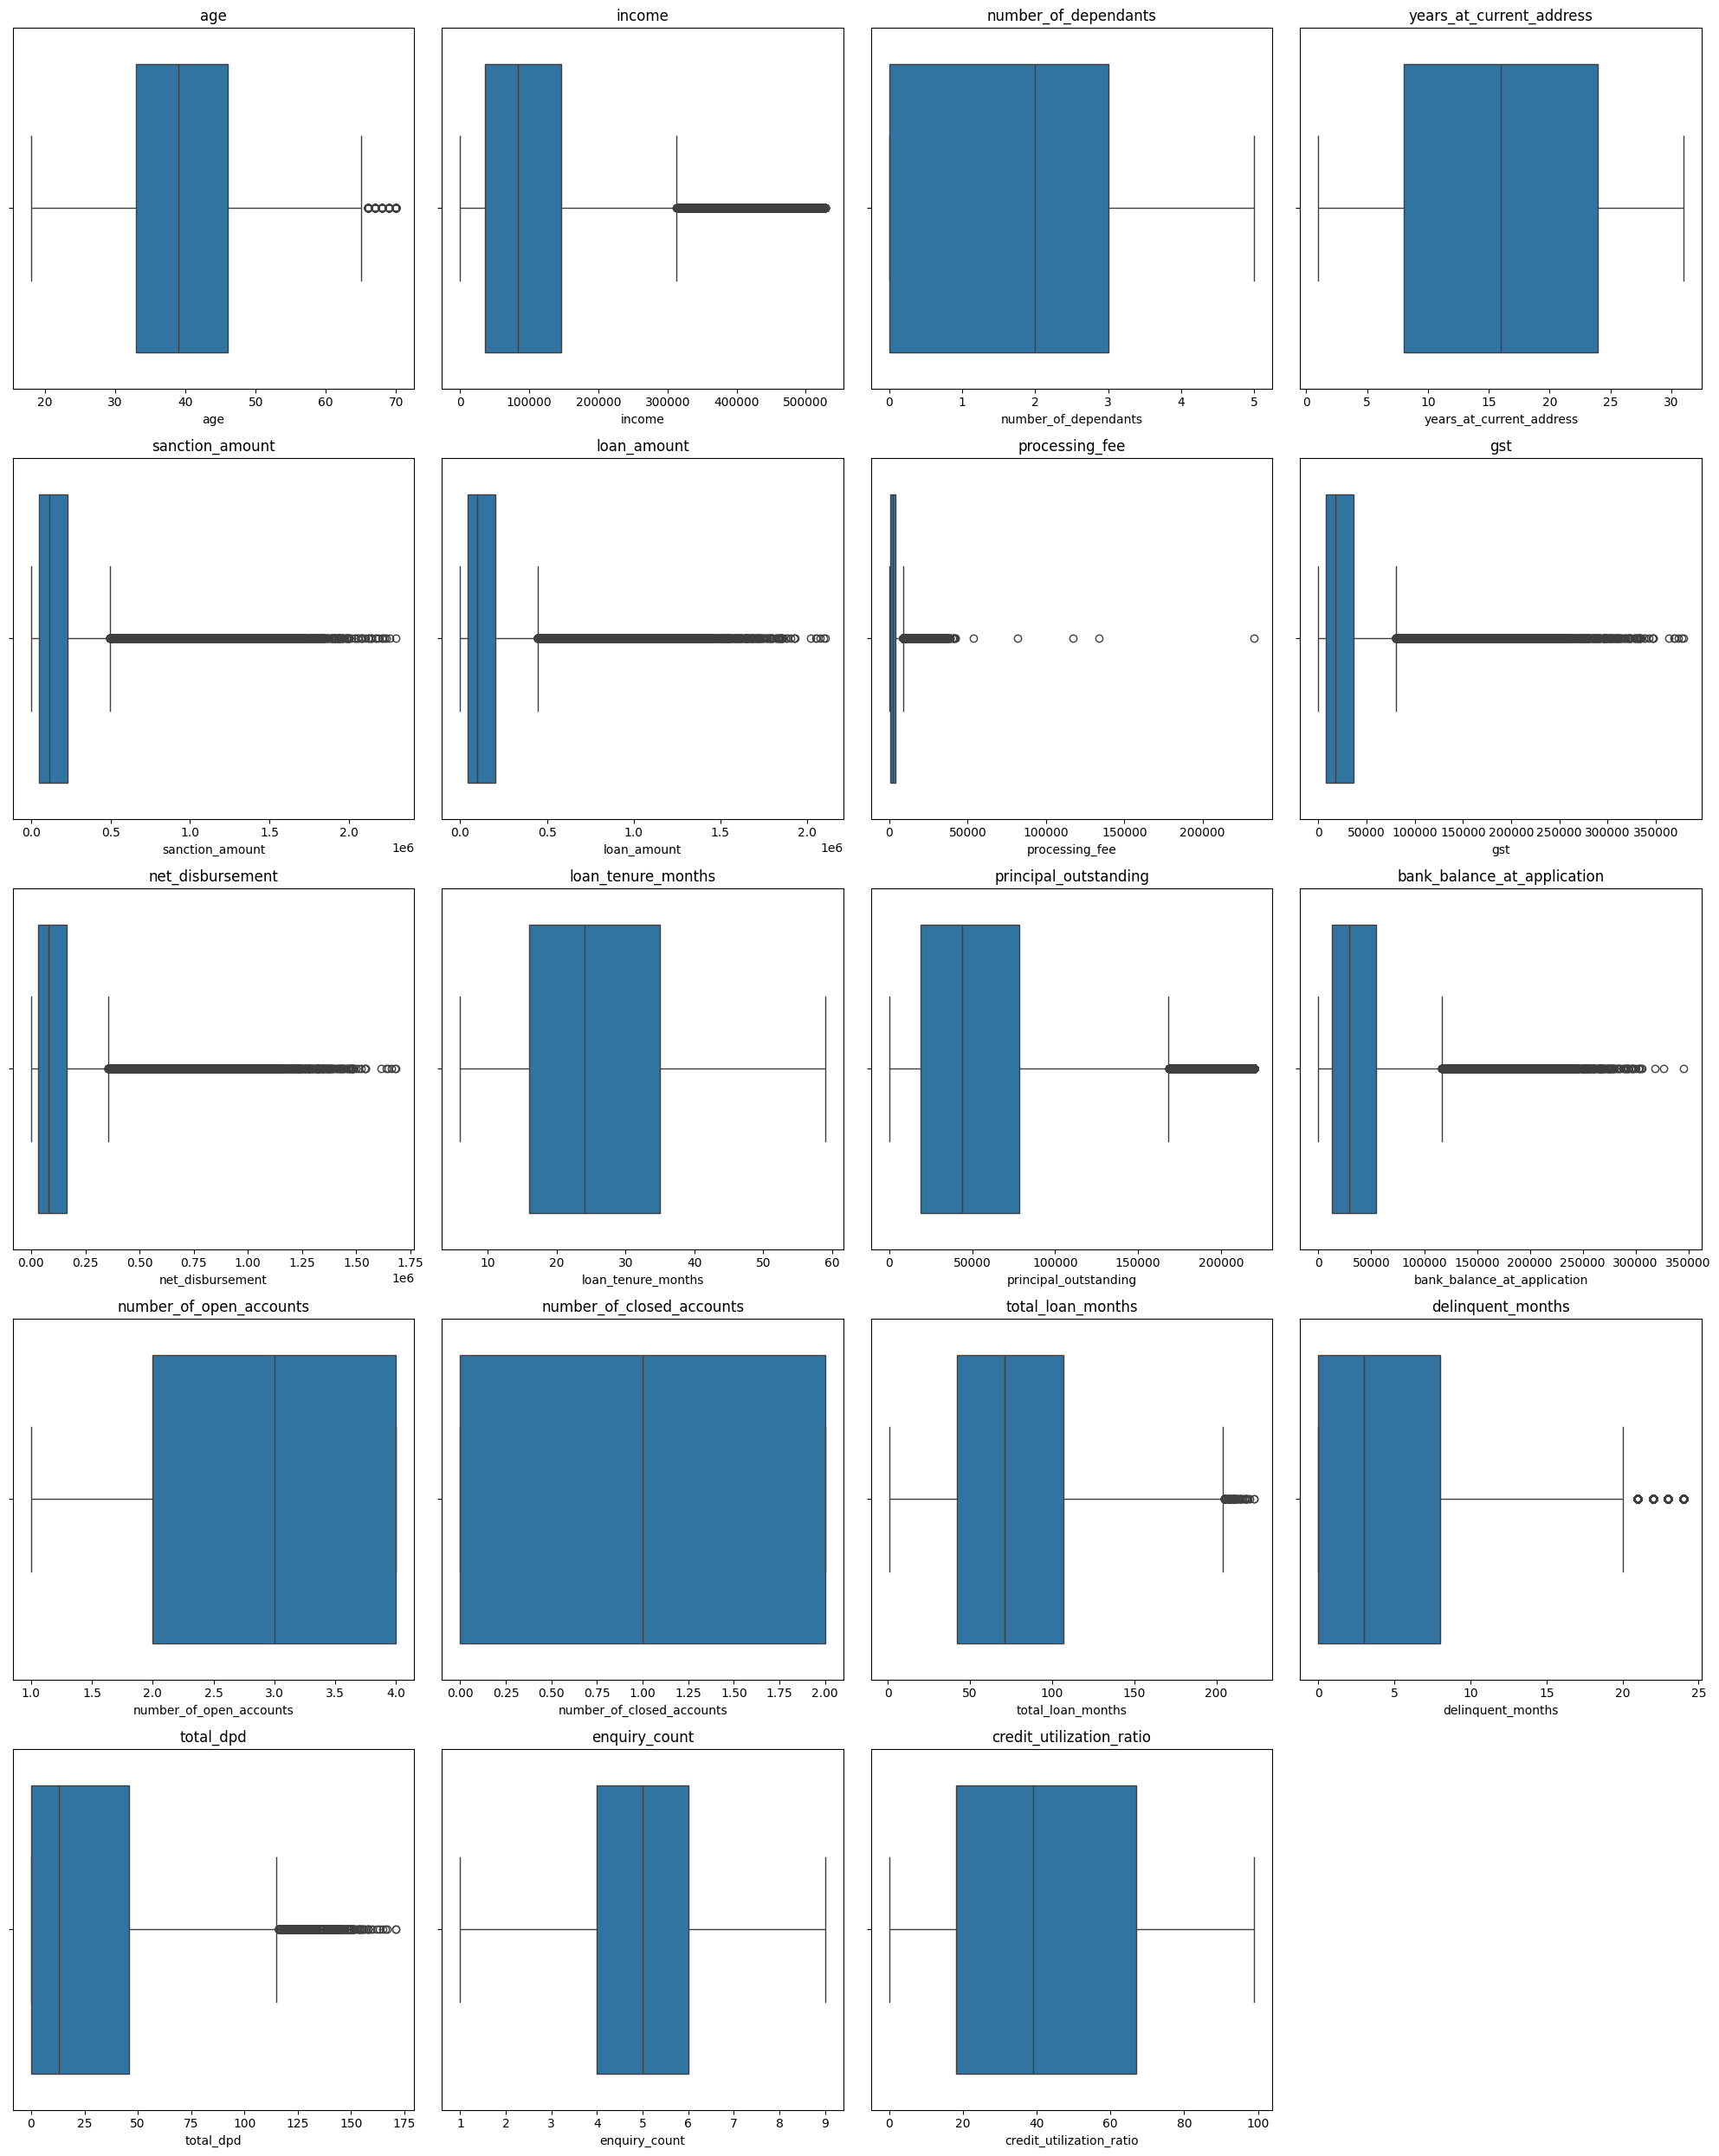

In [33]:
num_plots = len(numeric_columns)
num_cols = 4
num_rows = (num_plots + num_cols -1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
    
for j in range(i+1, num_rows * num_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

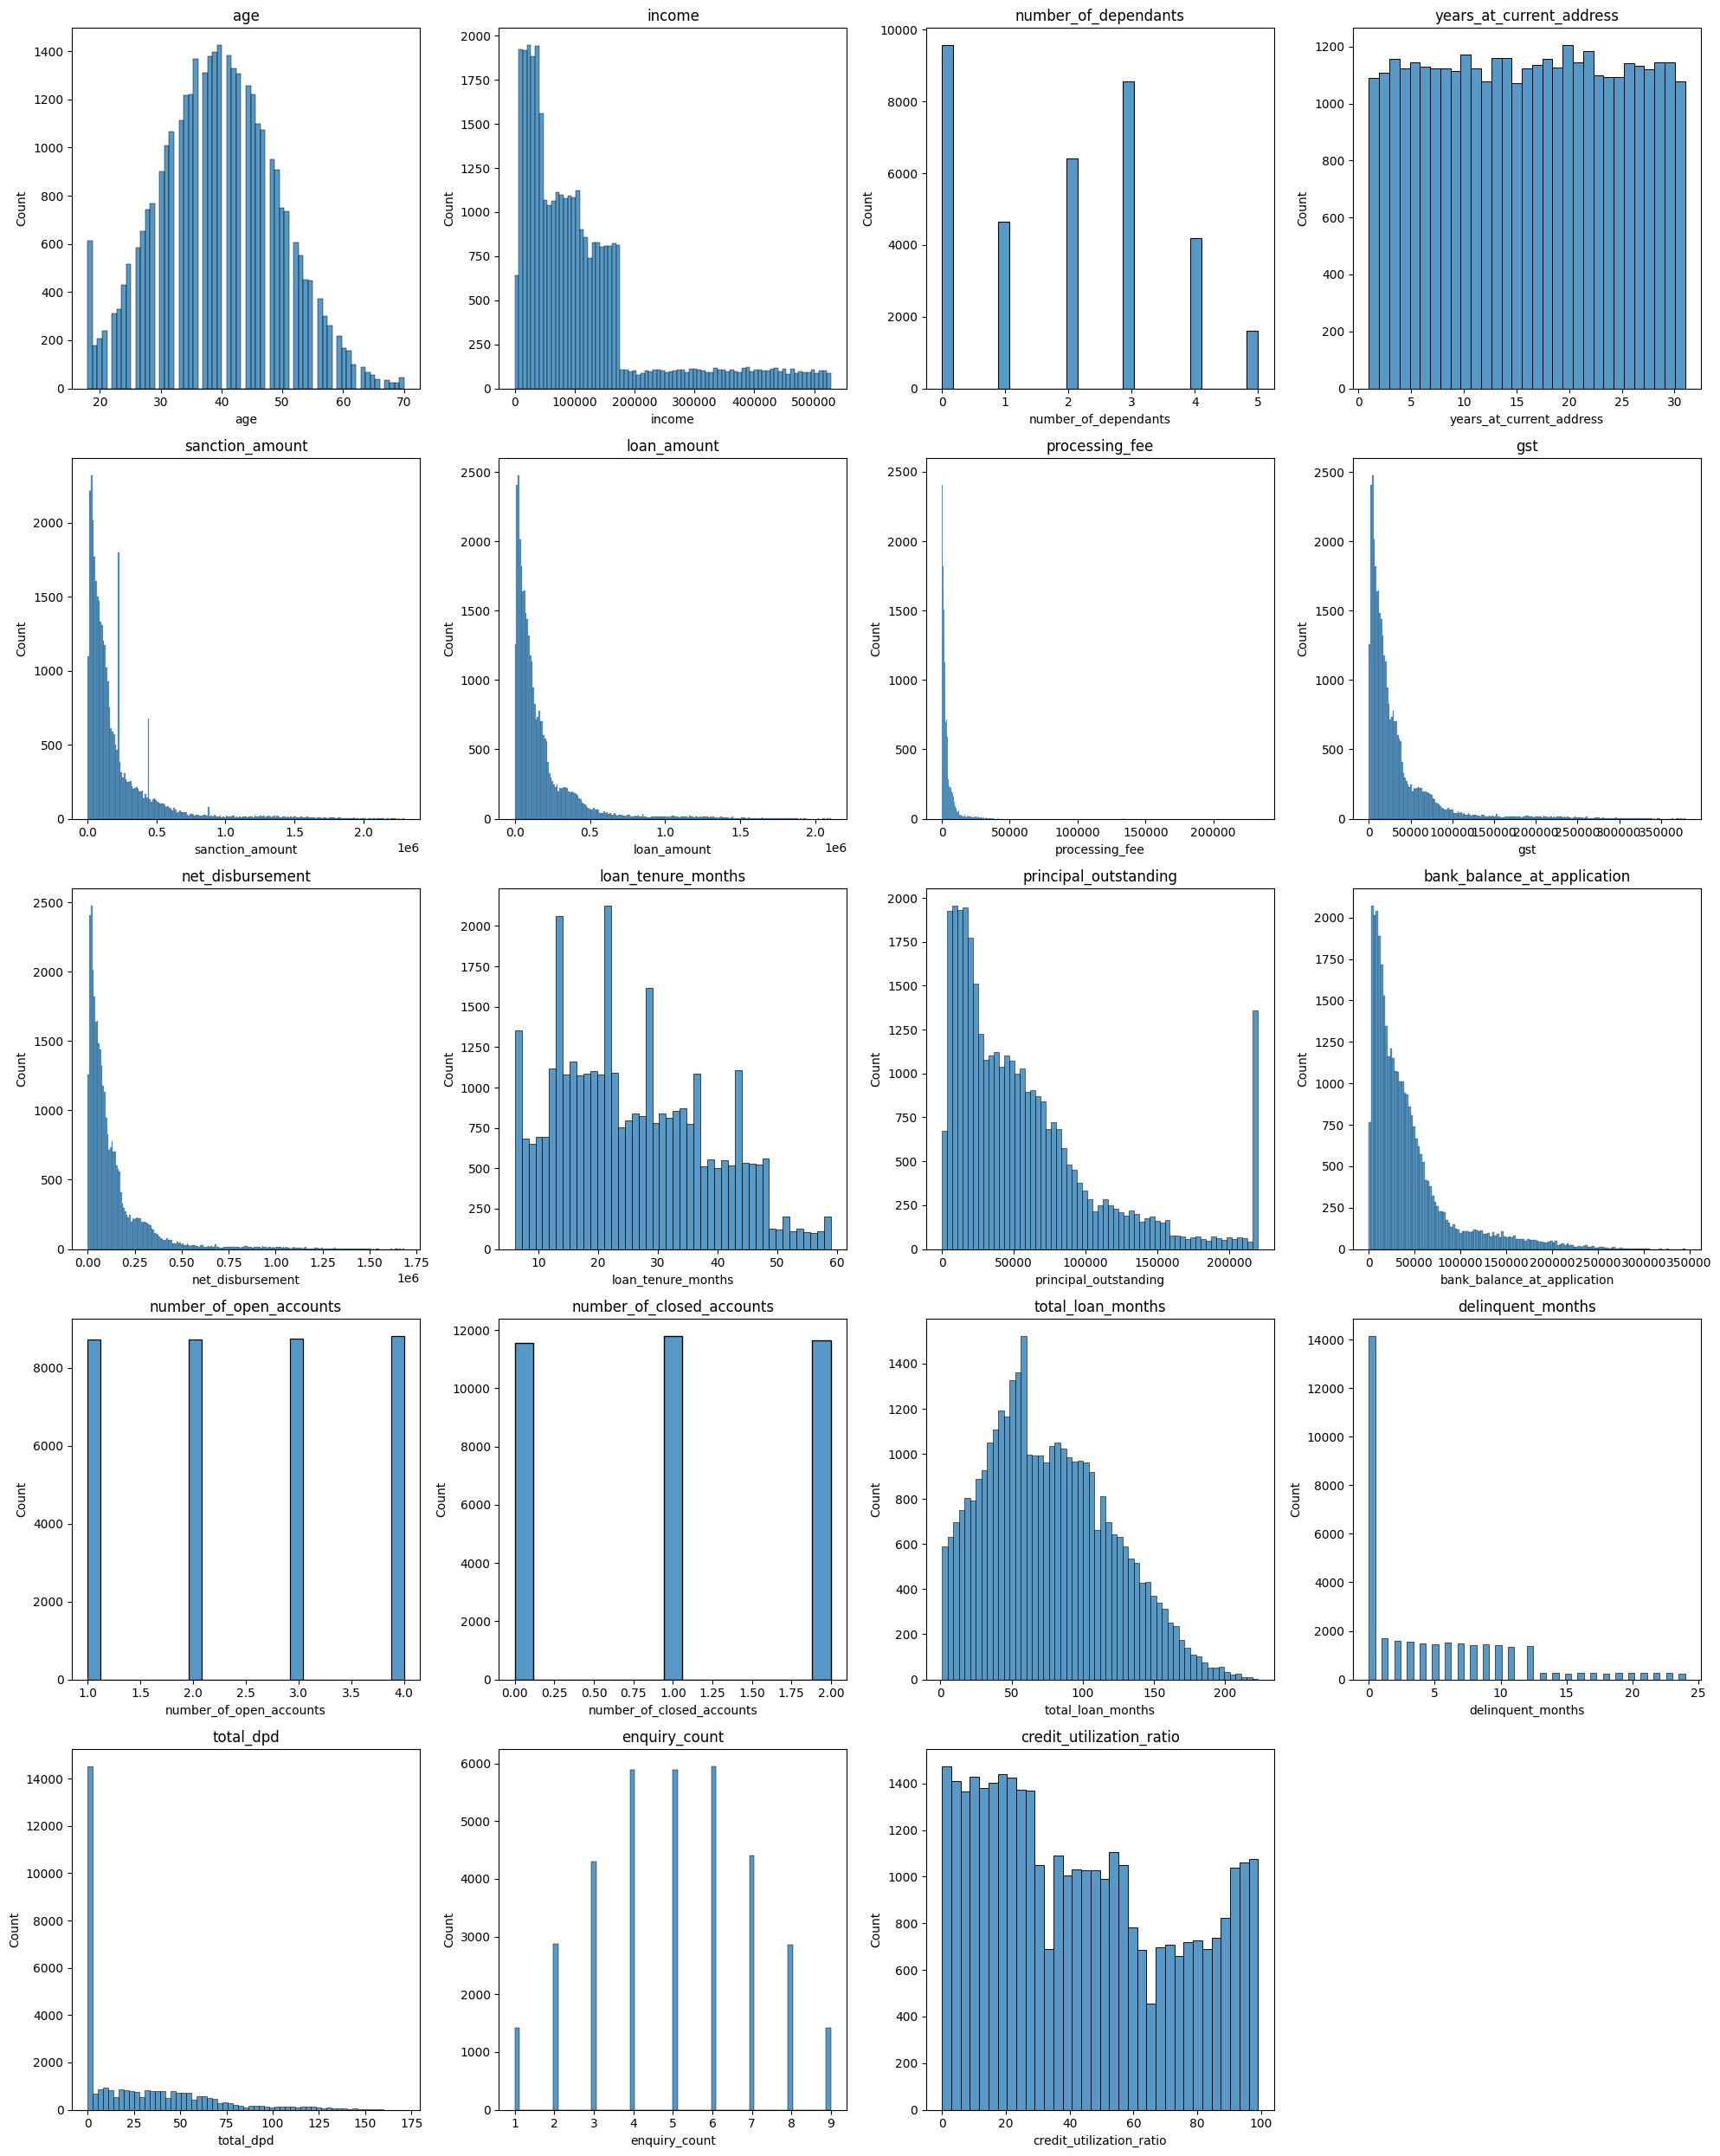

In [38]:
num_plots = len(numeric_columns)
num_cols = 4
num_rows = (num_plots + num_cols -1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
    
for j in range(i+1, num_rows * num_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

#### outliers in processing_fee column

In [39]:
df["processing_fee"].describe()

count     35000.000000
mean       3541.467965
std        5005.003127
min           0.000000
25%         847.440000
50%        1966.360000
75%        4073.520000
max      232915.915100
Name: processing_fee, dtype: float64

In [41]:
df[df["processing_fee"]== df["processing_fee"].max()]["loan_amount"]

6919    159544
Name: loan_amount, dtype: int64

In [49]:
#business context: if the processing fee is greater than 3% of the loan amount -> data error(outlier)
fee_outliers = df[(df["processing_fee"] / df["loan_amount"]) > 0.03]
fee_outliers

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
6919,C09899,56,M,Married,Self-Employed,393712,5,Owned,16,Gdansk,...,19.07.2020,11.08.2020,False,2,1,51,1,5,3,92
16723,C23982,33,F,Single,Self-Employed,78760,0,Rented,7,Bialystok,...,15.12.2021,14.01.2022,False,4,2,154,9,31,6,26
19626,C28175,36,F,Single,Self-Employed,49412,1,Rented,31,Katowice,...,18.05.2022,05.06.2022,False,3,0,111,8,41,3,62
20424,C29306,52,M,Married,Self-Employed,168916,2,Owned,11,Katowice,...,28.06.2022,21.07.2022,False,2,2,42,11,65,3,2
32942,C47090,37,M,Married,Self-Employed,83248,2,Rented,13,Krakow,...,07.04.2024,15.04.2024,False,3,0,112,5,33,3,32


In [54]:
df = df[(df["processing_fee"] / df["loan_amount"]) <= 0.03].copy()
df.shape

(34989, 33)

In [53]:
#applying same logic to processing_fee as to training df
df_val = df_val[(df_val["processing_fee"] / df_val["loan_amount"]) <= 0.03].copy()
df_test = df_test[(df_test["processing_fee"] / df_test["loan_amount"]) <= 0.03].copy()
df_val.shape, df_test.shape

((9997, 33), (4999, 33))

#### Categorical columns

In [55]:
for col in categorical_columns:
    print(col, "--", df[col].unique())

gender -- ['M' 'F']
marital_status -- ['Married' 'Single']
employment_status -- ['Self-Employed' 'Salaried']
residence_type -- ['Owned' 'Mortgage' 'Rented']
city -- ['Bydgoszcz' 'Poznan' 'Wroclaw' 'Gdansk' 'Warszawa' 'Katowice' 'Bialystok'
 'Lublin' 'Szczecin' 'Krakow']
state -- ['kujawsko-pomorskie' 'wielkopolskie' 'dolnoslaskie' 'pomorskie'
 'mazowieckie' 'slaskie' 'podlaskie' 'lubelskie' 'zachodniopomorskie'
 'malopolskie']
zipcode -- ['85-001' '60-001' '50-001' '80-001' '00-001' '40-001' '15-001' '20-001'
 '70-001' '30-001']
loan_purpose -- ['Auto' 'Home' 'Personal' 'Education' 'Personaal']
loan_type -- ['Secured' 'Unsecured']


In [56]:
df["loan_purpose"].value_counts()

loan_purpose
Personal     12245
Home         10558
Auto          6939
Education     5229
Personaal       18
Name: count, dtype: int64

In [59]:
df["loan_purpose"] = df["loan_purpose"].replace('Personaal', 'Personal')

#same logic for val/test dfs
df_val["loan_purpose"] = df_val["loan_purpose"].replace('Personaal', 'Personal')
df_test["loan_purpose"] = df_test["loan_purpose"].replace('Personaal', 'Personal')

<h3 align='center' style="color:pink"> Exploratory Data Analysis </h3>

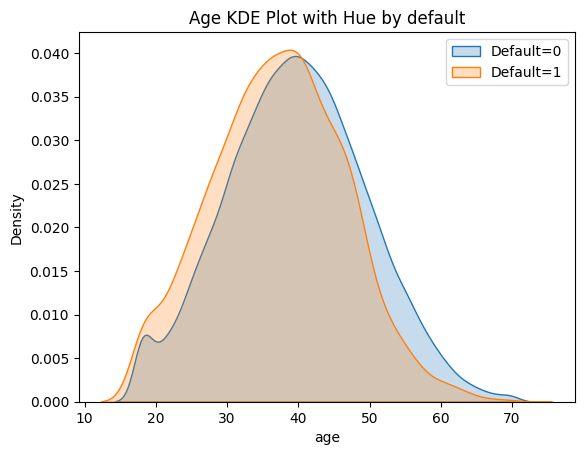

In [63]:
sns.kdeplot(df[df["default"]==0]["age"], fill=True, label='Default=0')
sns.kdeplot(df[df["default"]==1]["age"], fill=True, label='Default=1')
plt.title(f"Age KDE Plot with Hue by default")
plt.legend()
plt.show()

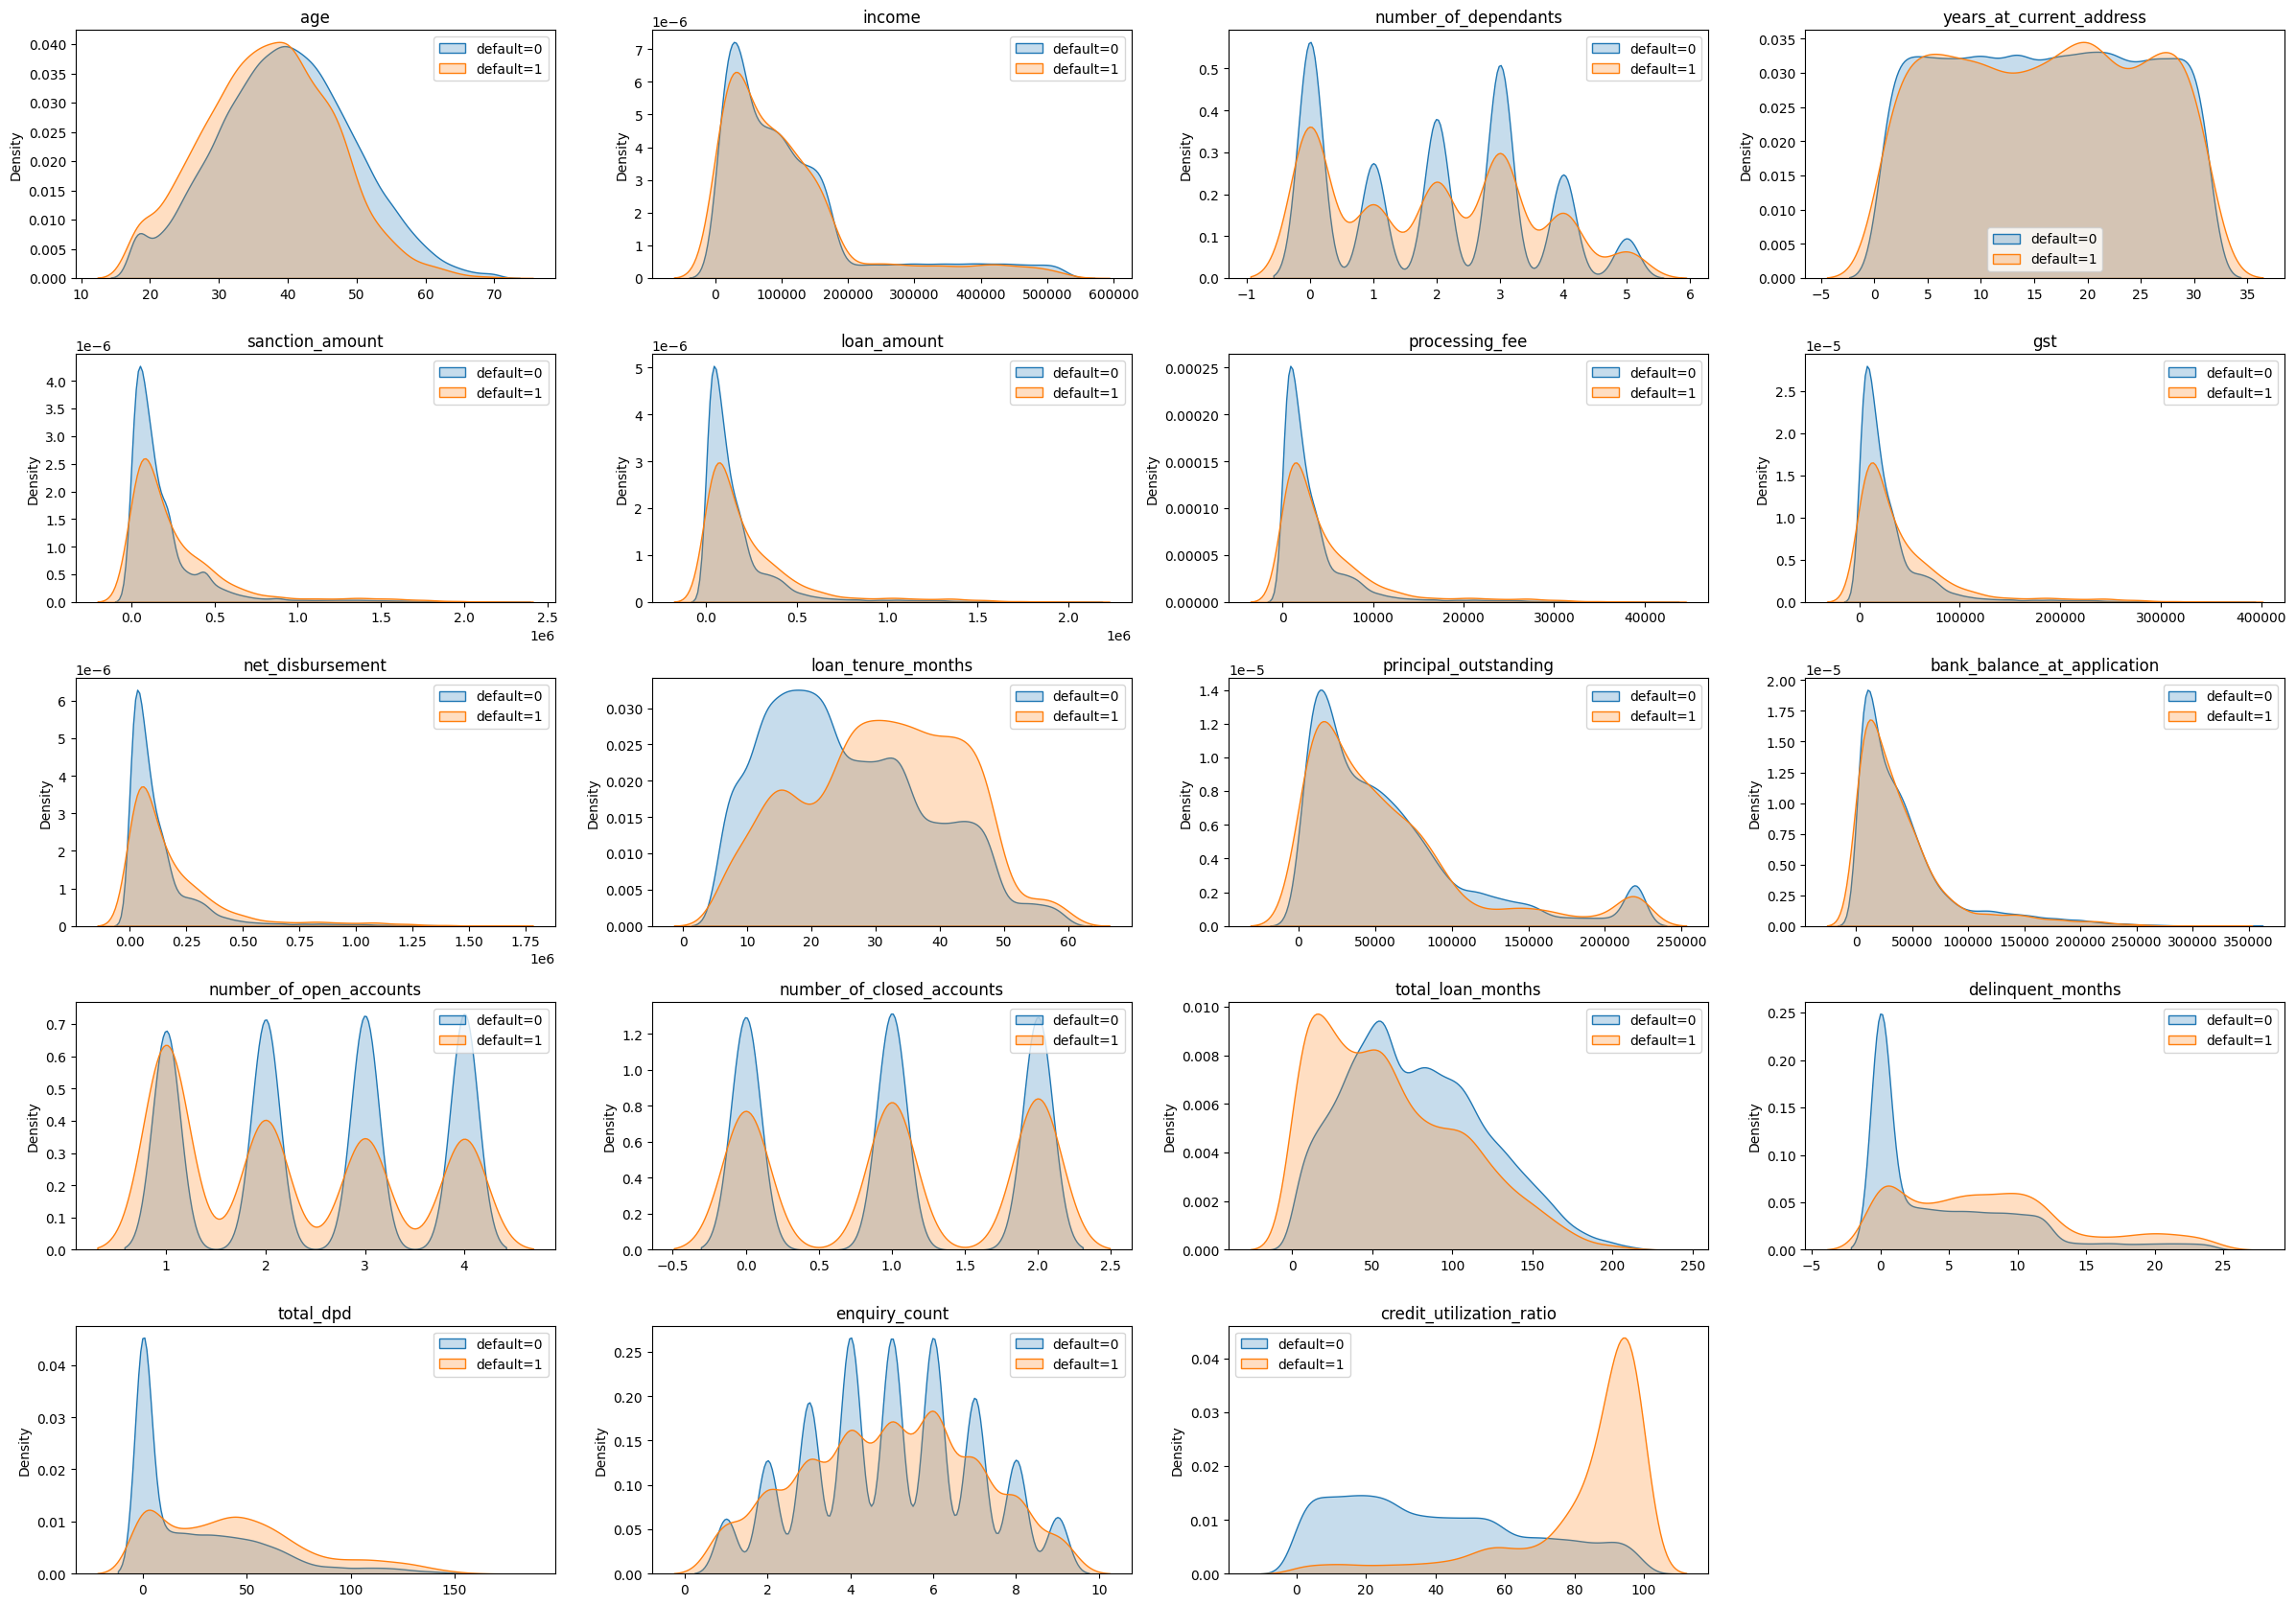

In [65]:
plt.figure(figsize=(24,20))

for i, col in enumerate(numeric_columns):
    plt.subplot(6,4, i+1)
    sns.kdeplot(df[col][df["default"]==0], fill=True, label='default=0')
    sns.kdeplot(df[col][df["default"]==1], fill=True, label='default=1')
    plt.title(col)
    plt.legend()
    plt.xlabel("")

plt.tight_layout()
plt.show()